In [1]:
import numpy as np
import math
import scipy.optimize as spo

CPCPH Method

2.78
0.67333335
1
[-0.97858196  0.3759384   1.7152098 ]
1.9699991
0.67333335
1.8619574
[-1.88828781 -1.17718296  0.12326101 -7.46187826  0.65929799]
[0.16579966 0.18692354 0.25132032]


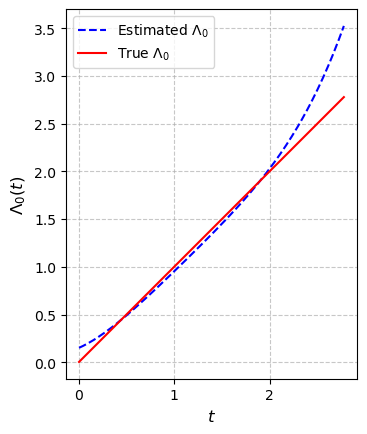

In [18]:
import numpy as np
import math
import scipy.optimize as spo
import matplotlib.pyplot as plt
from seed import set_seed
from data_generator import gendata_linear
from data_generator import search_c
from cpcph import cpcph
from LFD_LCP import LFDLCP
Theta = np.array([-1,0.5,1.5],dtype='float32') # beta=-1, intercept=0.5, gamma=1.5
zeta = 2
U_max = 3
pr = 0.7
c = search_c(pr, Theta, zeta, U_max, stepsize=0.01,B=5000,corr=0.5,seed=44,graph=False)['c']
print(c)
m = 4

set_seed(129)
train_data = gendata_linear(300,c,Theta,zeta,corr=0.5)
Z = train_data['Z']
Z_2 = train_data['Z_2']
De = train_data['De']
print(np.mean(De))
U  = train_data['U']
Res = cpcph(train_data, m, B=200, seq = 0.01, graph = True)
print(Res['C_index'])
print(Res['Theta'])
print(Res['zeta'])
print(np.mean(De))
print(np.mean(Z_2))
print(Res['phi'])
Lambda_U = Res['Lambda_U']
Theta = Res['Theta']
zeta = Res['zeta']
se = LFDLCP(train_data,Lambda_U,Theta,zeta)['se']
print(se)

结果矩阵：
        Bias β1     SE β1   Bias β2     SE β2   Bias β3     SE β3   Bias β4  \
n=100 -0.000043  0.010631  0.000489  0.009492 -0.000842  0.010771  0.001821   
n=300  0.000838  0.005723 -0.001042  0.006022  0.000327  0.006702  0.000390   
n=500  0.000658  0.004114 -0.000450  0.004260 -0.000551  0.004157  0.000140   

          SE β4   Bias β5     SE β5  
n=100  0.009709 -0.000247  0.010355  
n=300  0.005618 -0.000302  0.004870  
n=500  0.004415 -0.000092  0.003948  


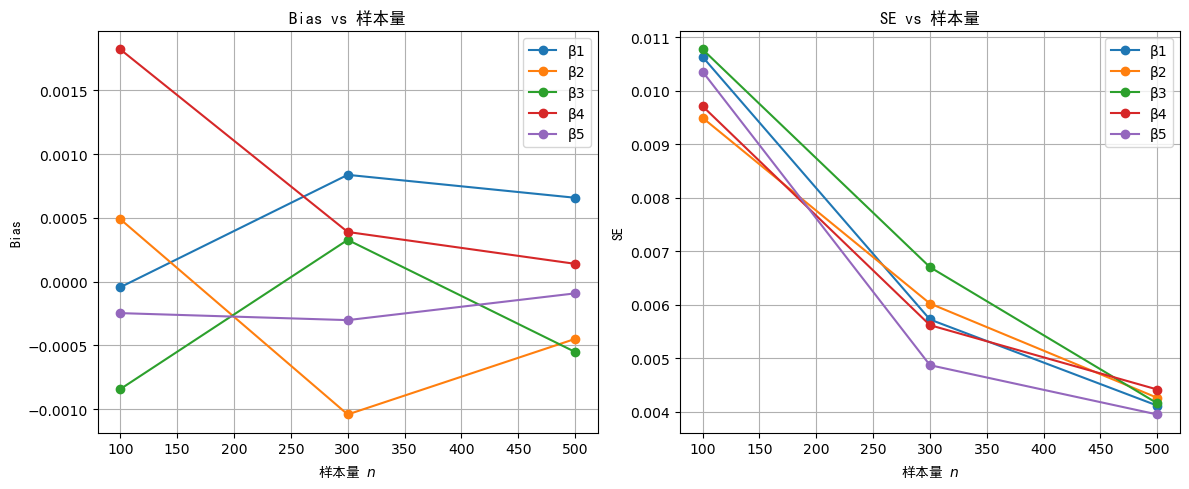

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 设置随机种子以确保可重复性
np.random.seed(42)

# 参数设置
p = 5  # 固定维数
n_values = [100, 300, 500]  # 样本量
R = 100  # 重复次数
true_beta = np.ones(p)  # 真实参数 beta，[1, 1, 1, 1, 1]

# 初始化结果矩阵：3 行 (n=100, 300, 500)，10 列 (bias_1, se_1, ..., bias_5, se_5)
results = np.zeros((3, 2 * p))

# 遍历每种样本量
for i, n in enumerate(n_values):
    # 初始化存储每次重复的 beta 估计
    beta_hats = np.zeros((R, p))
    
    # 重复 R 次
    for r in range(R):
        # 生成数据
        X = np.random.randn(n, p)  # 自变量 X，形状 (n, p)
        epsilon = np.random.randn(n) * 0.1  # 噪声，标准差 0.1
        y = X @ true_beta + epsilon  # 因变量 y
        
        # 最小二乘估计：(X^T X)^{-1} X^T y
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
        beta_hats[r, :] = beta_hat
    
    # 计算每个参数的 bias 和 se
    mean_beta_hat = np.mean(beta_hats, axis=0)  # 每个参数的均值
    bias = mean_beta_hat - true_beta  # 每个参数的 bias
    se = np.std(beta_hats, axis=0, ddof=1)  # 每个参数的 se
    
    # 存储结果：按 Bias βj, SE βj 交替排列
    for j in range(p):
        results[i, 2 * j] = bias[j]  # Bias βj
        results[i, 2 * j + 1] = se[j]  # SE βj

# 创建 DataFrame，列名为 Bias β1, SE β1, ..., Bias β5, SE β5
columns = [f'{stat} β{j+1}' for j in range(p) for stat in ['Bias', 'SE']]
index = [f'n={n}' for n in n_values]
results_df = pd.DataFrame(results, index=index, columns=columns)

# 打印结果
print("结果矩阵：")
print(results_df)

# 保存为 CSV 文件
# results_df.to_csv('linear_regression_p5_results.csv')

# 可选：可视化结果
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 绘制 Bias
for j in range(p):
    ax1.plot(n_values, results[:, 2 * j], marker='o', label=f'β{j+1}')
ax1.set_title(r'Bias vs 样本量', fontfamily='SimHei')
ax1.set_xlabel(r'样本量 $n$', fontfamily='SimHei')
ax1.set_ylabel(r'Bias', fontfamily='SimHei')
ax1.legend()
ax1.grid(True)

# 绘制 SE
for j in range(p):
    ax2.plot(n_values, results[:, 2 * j + 1], marker='o', label=f'β{j+1}')
ax2.set_title(r'SE vs 样本量', fontfamily='SimHei')
ax2.set_xlabel(r'样本量 $n$', fontfamily='SimHei')
ax2.set_ylabel(r'SE', fontfamily='SimHei')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

m out of n bootstrap: select m

In [1]:
import numpy as np
np.seterr(over='ignore')
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
import math
import scipy.optimize as spo
import matplotlib.pyplot as plt
from seed import set_seed
from data_generator import gendata_linear
from data_generator import search_c
from cpcph import cpcph
from mn_boot import mn_boot
Theta = np.array([-1,0.5,1.5],dtype='float32') # beta=-1, intercept=0.5, gamma=1.5
zeta = 2
U_max = 3
pr = 0.5
c = search_c(pr, Theta, zeta, U_max, stepsize=0.01,B=5000,corr=0.5,seed=44,graph=False)['c']
print(c)
m = 3

set_seed(1919)
data = gendata_linear(500,c,Theta,zeta,corr=0.5) 

q = 5
m1 = mn_boot(data,q,m,boot=100,seed=42,B=100,seq=0.01)
print(m1)

1.23
300


Change point interval

In [3]:
zeta = 2
from mn_boot import interval_zeta
interval_zeta(data,m1,zeta,m=3,B=100,seq=0.01,seed=42,alpha=0.05)

{'inter_length': np.float32(0.8200002),
 'interval': array([1.5079999, 2.492    ], dtype=float32)}

Test for Cox Model

1.54
[-0.9099451  0.8791819]
[-17.82301052  -0.28682702  -3.50610091  -0.0760609 ]
1


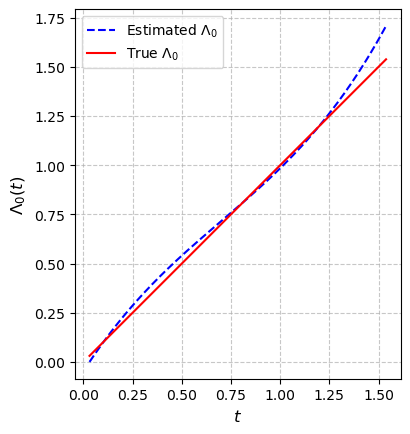

In [6]:
import numpy as np
np.seterr(over='ignore')
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
import math
import scipy.optimize as spo
import matplotlib.pyplot as plt
from seed import set_seed
from data_generator import gendata_linear_cox
from data_generator import search_c_cox
from cph import cph
Theta = np.array([-1,1],dtype='float32') # beta=-1, intercept=0.5, gamma=1.5
U_max = 3
pr = 0.5
c = search_c_cox(pr, Theta, U_max, stepsize=0.01,B=1000,corr=0.5,seed=44,graph=False)['c']
print(c)
m = 3

set_seed(1919)
train_data = gendata_linear_cox(300,c,Theta,corr=0.5) 
Res_cox = cph(train_data, m, B=200, seq = 0.01, graph = True)
print(Res_cox['Theta'])
print(Res_cox['phi'])
print(Res_cox['C_index'])

1.57
0.506
[-1.0136125]


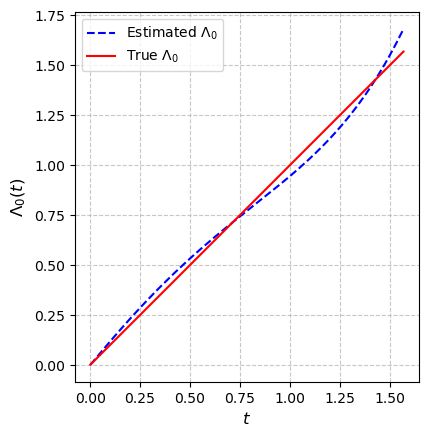

In [8]:
import numpy as np
import random
from data_generator import gendata_linear
from cph import cph 
from seed import set_seed 
from data_generator import search_c



Theta = np.array([-1,0,0],dtype='float32') # beta=-1, intercept=0.5, gamma=1.5
zeta = 2
U_max = 3
pr = 0.5
c = search_c(pr, Theta, zeta, U_max, stepsize=0.01,B=5000,corr=0.5,seed=44,graph=False)['c']
print(c)
m = 4

set_seed(115)
train_data = gendata_linear(500,c,Theta,zeta,corr=0.5)
Z = train_data['Z']
Z_2 = train_data['Z_2']
De = train_data['De']
print(np.mean(De))
U  = train_data['U']

Res_cox = cph(train_data, m, graph=True)
print(Res_cox['Theta'])


Test for SUP test

In [4]:
import numpy as np
import random
from data_generator import gendata_linear
from cph import cph 
from seed import set_seed 
from data_generator import search_c
from SUPtest import SUP_test
K = 5

Theta = np.array([-1,0.5,0.5],dtype='float32') # beta=-1, intercept=0.5, gamma=1.5
zeta = 2
U_max = 3
pr = 0.5
c = search_c(pr, Theta, zeta, U_max, stepsize=0.01,B=5000,corr=0.5,seed=44,graph=False)['c']
print(c)
m = 4

set_seed(126)
train_data = gendata_linear(500,c,Theta,zeta,corr=0.5)
SUP_test(train_data, m, K=5, boot = 1000, alpha=0.05, seed = 42)

1.21


{'Decision': np.int64(1),
 'Statistic': np.float32(5.687969),
 'Quantile': np.float32(4.5863786),
 'P_value': np.float64(0.028000000000000025)}